In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
import torch
from torch import eye
sys.path.append("..")

In [3]:
from src.datagen.kernels import *
from src.datagen.gpcurve import *

In [4]:
num_total_points = 50
space_values = (
    torch.linspace(-2, 2, num_total_points)
    .unsqueeze(0)
    .repeat_interleave(repeats=16, axis=0)
).unsqueeze(-1)
time_values = (
    torch.linspace(-2, 2, num_total_points)
    .unsqueeze(0)
    .repeat_interleave(repeats=16, axis=0)
).unsqueeze(-1)

In [5]:
x_dim = 1
y_dim = 1
MAX_CONTEXT_POINTS = 16
random_kernel_parameters = False
BATCH_SIZE = 16
l1_scale=4
l2_scale=1

In [6]:
l1, sigma_f = generate_lengthscale_sigma_f(
    random_kernel_parameters, 
    BATCH_SIZE, 
    y_size=1, 
    x_size=1, 
    l1_scale=l1_scale, 
    sigma_scale=1
)

In [7]:
l2, sigma_f = generate_lengthscale_sigma_f(
    random_kernel_parameters, 
    BATCH_SIZE, 
    y_size=1, 
    x_size=1, 
    l1_scale=l2_scale, 
    sigma_scale=1
)

In [8]:
L1 = torch.cholesky(rbf_kernel(space_values, l1, sigma_f).double()).float()

In [9]:
L2 = torch.cholesky(rbf_kernel(time_values, l1, sigma_f).double()).float()

In [10]:
Tensor(16, 1, num_total_points**2, 1).normal_().shape

torch.Size([16, 1, 2500, 1])

In [11]:
kron_kernel = torch.zeros(16, 1, 2500, 2500)

for i in range(16):
    kron_kernel[i][0] = torch.Tensor(np.kron(L1.squeeze(1).numpy()[i,:,:], L2.squeeze(1).numpy()[i,:,:] ))

In [12]:
r = kron_kernel @ torch.Tensor(16, 1, num_total_points**2, 1).normal_()

In [13]:
r.squeeze(1).shape

torch.Size([16, 2500, 1])

In [14]:
(time_values.squeeze(1)
.repeat_interleave(repeats=50, axis=1)
).shape

torch.Size([16, 2500, 1])

In [15]:
target_x = torch.zeros(16, 2500, 2)

In [16]:
target_x[:,:,0] = (time_values.squeeze(1)
.repeat_interleave(repeats=50, axis=1)
).squeeze(2)

In [17]:
index=50
for i in range(50):
    target_x[:, index:index+50,1] = space_values[:,i,0].unsqueeze(1)
    index += 50

In [18]:
datagen = ProductRBFCurvesReader(1, 50, testing=True, random_kernel_parameters=False)

In [19]:
import matplotlib.pyplot as plt

In [20]:
data_test= datagen.generate_curves()
x_context = data_test.query[0][0].contiguous()
y_context = data_test.query[0][1].contiguous()
x_target = data_test.query[1].contiguous()
y_target = data_test.target_y.contiguous()

In [21]:
x_target

tensor([[[-2.0000,  0.0000],
         [-2.0000,  0.0000],
         [-2.0000,  0.0000],
         ...,
         [ 2.0000,  1.9184],
         [ 2.0000,  1.9184],
         [ 2.0000,  1.9184]]])

In [33]:
(time_values.squeeze(1).repeat_interleave(
 repeats=int(num_total_points), axis=2
)
).squeeze(2).shape

torch.Size([16, 50, 50])

In [43]:
num_target = 50
num_total_points = num_target
space_values = (
    torch.linspace(-2, 2, int(num_total_points))
    .unsqueeze(0)
    .repeat_interleave(repeats=1, axis=0)
).unsqueeze(-1)
time_values = (
    torch.linspace(-2, 2, int(num_total_points))
    .unsqueeze(0)
    .repeat_interleave(repeats=1, axis=0)
).unsqueeze(-1)

In [58]:
x_values = torch.zeros(1, 50 ** 2, 2)
index = 0
for i in range(50):
    x_values[:, index : index + 50, 1] = space_values[
        :, i, 0
    ].unsqueeze(1)
    x_values[:, index : index + 50, 0] = time_values[:, :, 0]
    index += 50

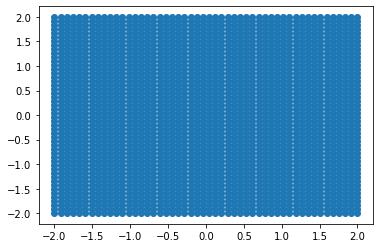

In [59]:
plt.scatter(x_values[:,:,0], x_values[:,:,1])